## Author: Ganesh Kale
## Week#7
## Date: Jan 28, 2021

# Create Optimal Hotel Recommendations

 

## Intro & Background:

Expedia is interested in predicting which hotel group a user is going to book. Expedia has in-house algorithms to form hotel clusters, where similar hotels for a search (based on historical price, customer star ratings, geographical locations relative to city center, etc) are grouped together. These hotel clusters serve as good identifiers to which types of hotels people are going to book, while avoiding outliers such as new hotels that don't have historical data.

Expedia has provided you logs of customer behavior. These include what customers searched for, how they interacted with search results (click/book), whether or not the search result was a travel package. The data in this competition is a random selection from Expedia and is not representative of the overall statistics.

## Problem Statement:

The goal of this project is to predict the booking outcome (hotel cluster) for a user event, based on their search and other attributes associated with that user event.

## Data Info:

The data is from 2013 and 2014,the data includes all the users in the logs, including both click events and booking events.

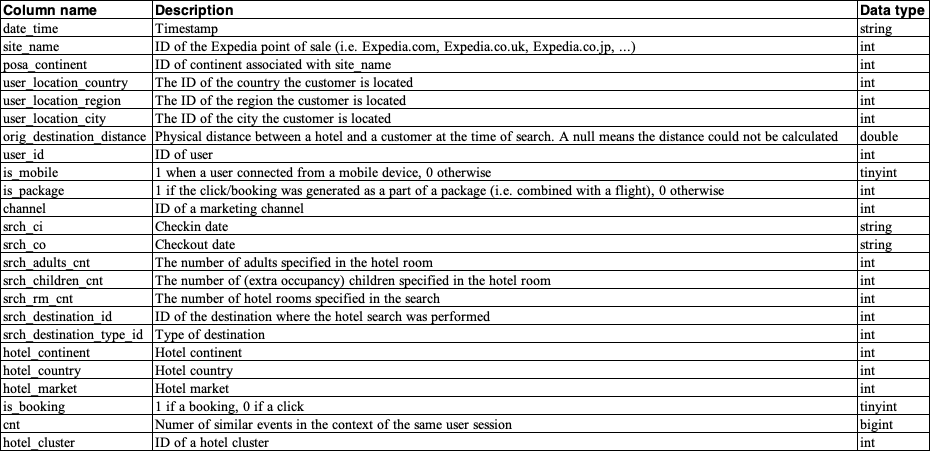

#### _Import required packages_

In [1]:
import numpy as np  # for numeric operations
import pandas as pd  # for data manipulation
import matplotlib.pyplot as plt  # for data visualization
import seaborn as sns  # for data visualization
from sklearn.preprocessing import LabelEncoder


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [15]:
# import the dataset

hotels = pd.read_csv("Data/hotel_data.csv")

In [20]:
# take sample from hotels df since data size is huge

hotels = hotels.sample(500000)

# display shape and head of df

hotels.shape
hotels.head()

(500000, 24)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
19838335,2013-03-09 11:57:08,11,3,205,354,25315,4030.0329,964389,0,0,...,0,1,8293,1,0,1,6,46,39,46
7976168,2014-06-29 13:48:21,2,3,95,38,17209,NaN,510966,0,0,...,0,1,12247,6,0,2,6,204,27,21
27203416,2014-01-08 02:46:09,2,3,162,13,34170,NaN,439290,0,0,...,1,1,12450,5,1,1,2,50,191,95
7324050,2013-04-04 12:47:40,2,3,66,174,54057,NaN,1093869,0,0,...,0,4,55208,1,0,3,6,204,941,82
1632788,2013-08-05 13:45:56,2,3,182,393,11124,6071.5452,367851,0,0,...,0,2,21777,6,0,1,6,208,1480,86


In [26]:
# display info of df - datatypes and counts

hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 19838335 to 28680585
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date_time                  500000 non-null  datetime64[ns]
 1   site_name                  500000 non-null  int64         
 2   posa_continent             500000 non-null  int64         
 3   user_location_country      500000 non-null  int64         
 4   user_location_region       500000 non-null  int64         
 5   user_location_city         500000 non-null  int64         
 6   orig_destination_distance  320584 non-null  float64       
 7   user_id                    500000 non-null  int64         
 8   is_mobile                  500000 non-null  int64         
 9   is_package                 500000 non-null  int64         
 10  channel                    500000 non-null  int64         
 11  srch_ci                    499357 non-null 

## _Data Prep:_

- Update features data types
- Handle Missing values
- update index
- Feature Engineering

In [24]:
# change date_time feature to datetime datatype

hotels['date_time'] = pd.to_datetime(hotels['date_time'])

In [25]:
# display the user event by year

hotels['date_time'].dt.year.value_counts()

2014    352132
2013    147868
Name: date_time, dtype: int64

#### Insights:

It seems the we have more user event logs from 2014 year than 2013 in dataset.

In [27]:
# drop unnecessary columns, these columns won't be useful in analysis and prediction

hotels = hotels.drop(['date_time','site_name', 'user_location_region', 'user_location_city', 'orig_destination_distance', 
                              'user_id', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', 'cnt'],axis=1)

In [28]:
# check for missing values

hotels.isna().sum()

posa_continent                0
user_location_country         0
is_mobile                     0
is_package                    0
channel                       0
srch_ci                     643
srch_destination_id           0
srch_destination_type_id      0
is_booking                    0
hotel_continent               0
hotel_country                 0
hotel_market                  0
hotel_cluster                 0
dtype: int64

<AxesSubplot:>

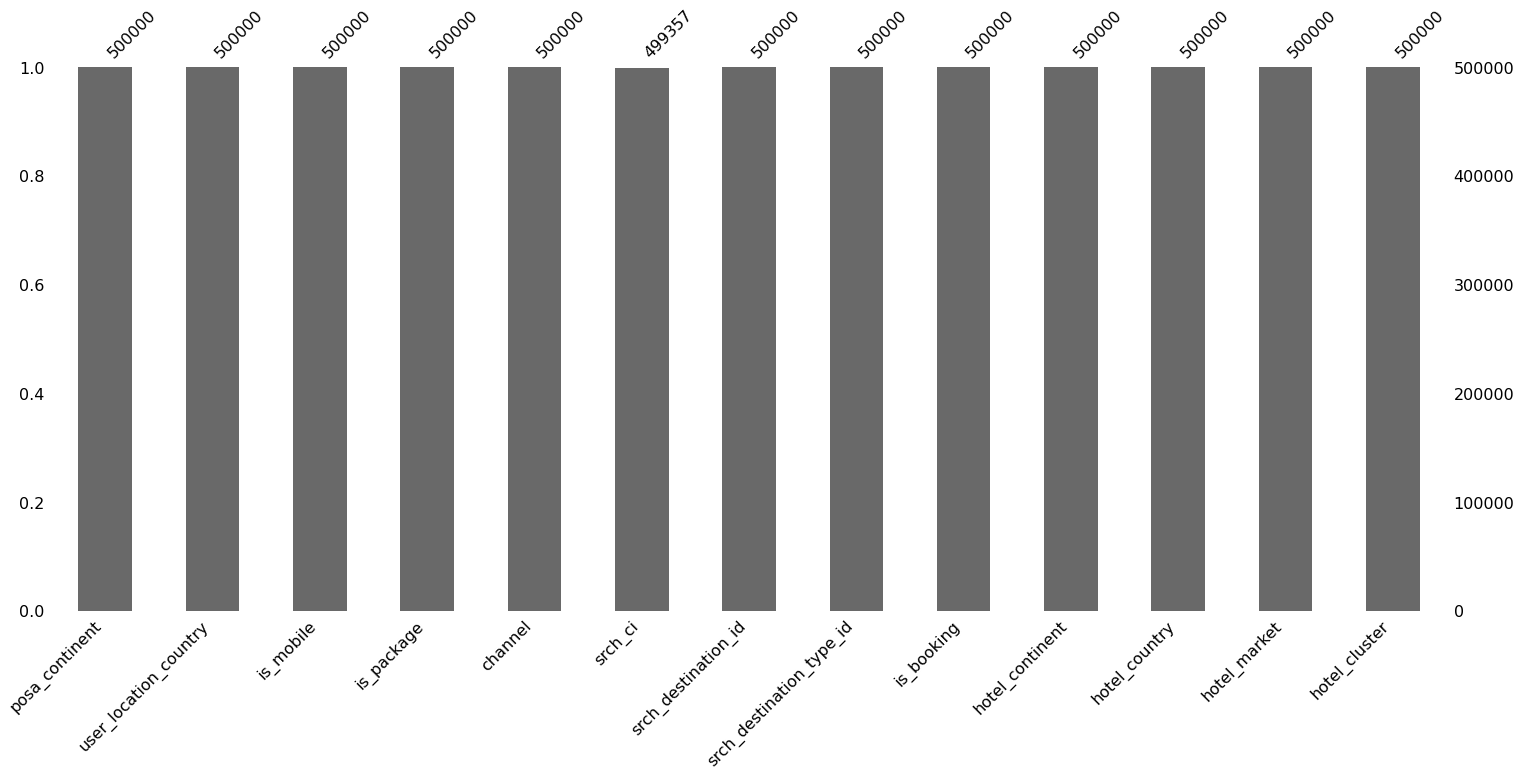

In [30]:
# plot missing values plot

import missingno as msno

msno.bar(hotels)

#### Insights:

The feature srch_ci which is check-in date having few missing values, so we are going to update them since we need this feature and we are going to split it into year and month.

<AxesSubplot:>

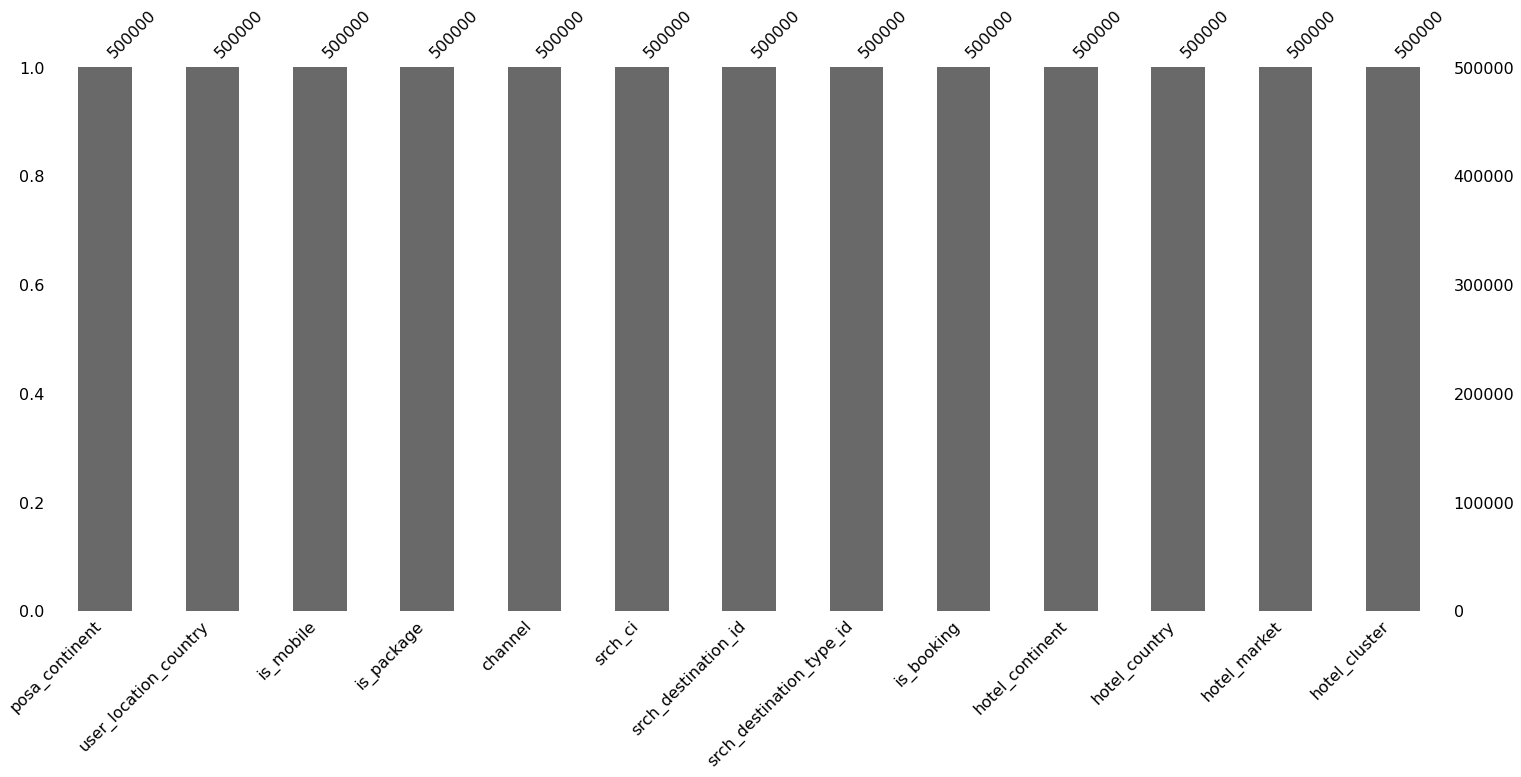

In [31]:
# fill missing values

hotels = hotels.fillna(method='ffill')
msno.bar(hotels)

In [33]:
# reset index

hotels = hotels.reset_index(drop=True)

hotels.head()

,posa_continent,user_location_country,is_mobile,is_package,channel,srch_ci,srch_destination_id,srch_destination_type_id,is_booking,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,3,205,0,0,9,2013-05-30,8293,1,0,6,46,39,46
1,3,95,0,0,9,2014-06-30,12247,6,0,6,204,27,21
2,3,162,0,0,9,2014-01-13,12450,5,1,2,50,191,95
3,3,66,0,0,2,2013-06-20,55208,1,0,6,204,941,82
4,3,182,0,0,9,2013-08-17,21777,6,0,6,208,1480,86


In [39]:
# split srch_ci into month year & week

hotels['srch_ci'] = pd.to_datetime(hotels['srch_ci'])

hotels['ci_year'] = hotels['srch_ci'].dt.year
hotels['ci_month'] = hotels['srch_ci'].dt.month
hotels['ci_week'] = hotels['srch_ci'].dt.week

/var/folders/k4/cx9xdwy96n56t56mbr585v5h0000gn/T/ipykernel_8606/1624812354.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  hotels['ci_week'] = hotels['srch_ci'].dt.week


## _Exploratory Data Analysis:_

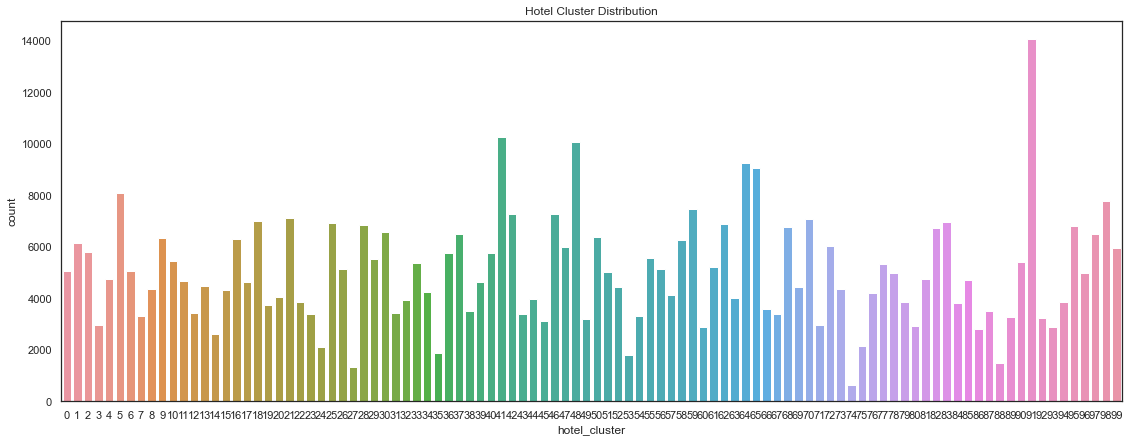

In [51]:
# hotel cluster distribution

sns.set(style='white')
plt.figure(figsize=(19,7))

sns.countplot(data=hotels,x='hotel_cluster')
plt.title('Hotel Cluster Distribution');

#### _Insights:_

From above chart, we see that hotel cluster 91 is dese compared to others but overall its almost uniformly distributed acrross different clusters.

/Users/ganeshkale/work/virtual_envs/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


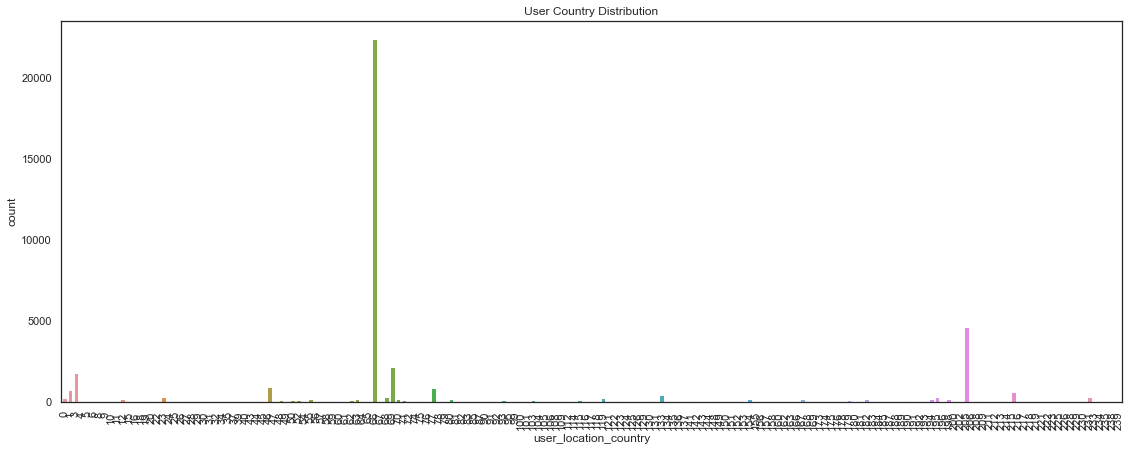

In [63]:
# contries user travel from

bookings = hotels.loc[hotels['is_booking']==1]

sns.set(style='white')
plt.figure(figsize=(19,7))

sns.countplot('user_location_country',data=bookings.sort_values(by=['user_location_country']))
plt.title('User Country Distribution')
plt.xticks(rotation = 90);

/Users/ganeshkale/work/virtual_envs/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


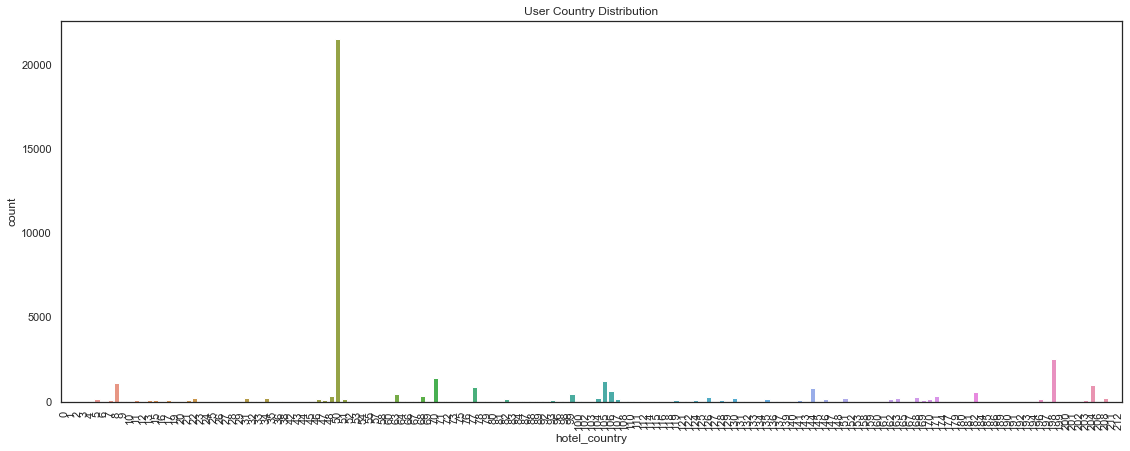

In [65]:
# contries user travel to - destination contries distribution

sns.set(style='white')
plt.figure(figsize=(19,7))

sns.countplot('hotel_country',data=bookings.sort_values(by=['user_location_country']))
plt.title('User Country Distribution')
plt.xticks(rotation = 90);

#### Insights:

Based on baove two charts, it shows that majority of the users are from country code 66 and majority of the users prefer to country code 50.

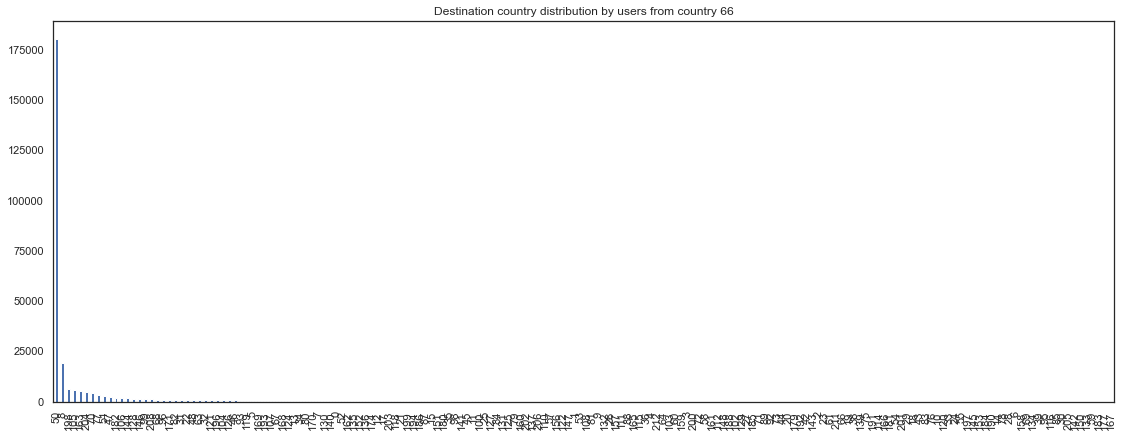

In [68]:
# plot chart to see users from country code 66 are prefered to travel i.e. destination country

plt.figure(figsize=(19,7))

major_country =  hotels.loc[hotels['user_location_country']==66]
major_country['hotel_country'].value_counts().plot(kind='bar')
plt.title('Destination country distribution by users from country 66')
plt.xticks(rotation = 90);

#### _Insights:_

It is consistent with all other user countries that the destination country 50 is the mostly prefered from users with country code 66 as well.

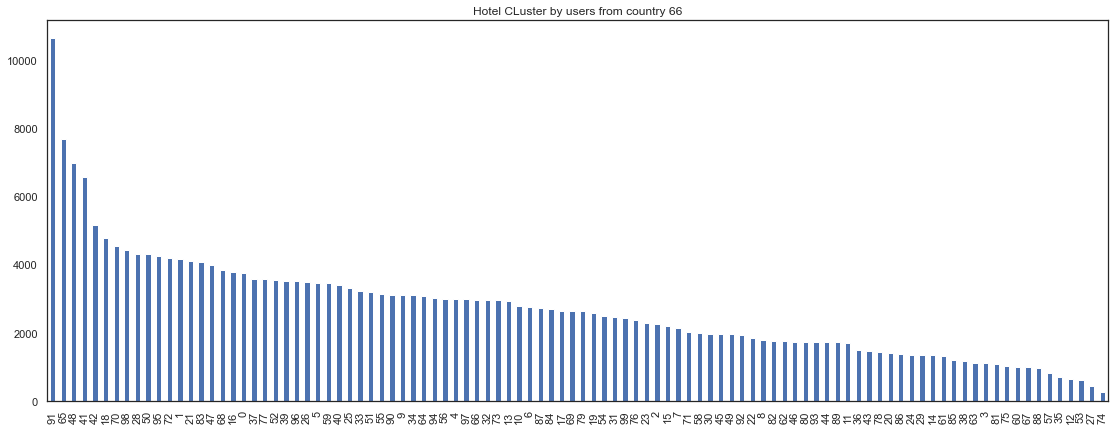

In [81]:
# see what hotels clusters are booked by users from country 66

plt.figure(figsize=(19,7))

major_country =  hotels.loc[hotels['user_location_country']==66]
major_country['hotel_cluster'].value_counts().plot(kind='bar')
plt.title('Hotel CLuster by users from country 66')
plt.xticks(rotation = 90);

#### _Insights:_

It shows that hotel cluster 91 is popular and is prefered mostly from users of country code 66.

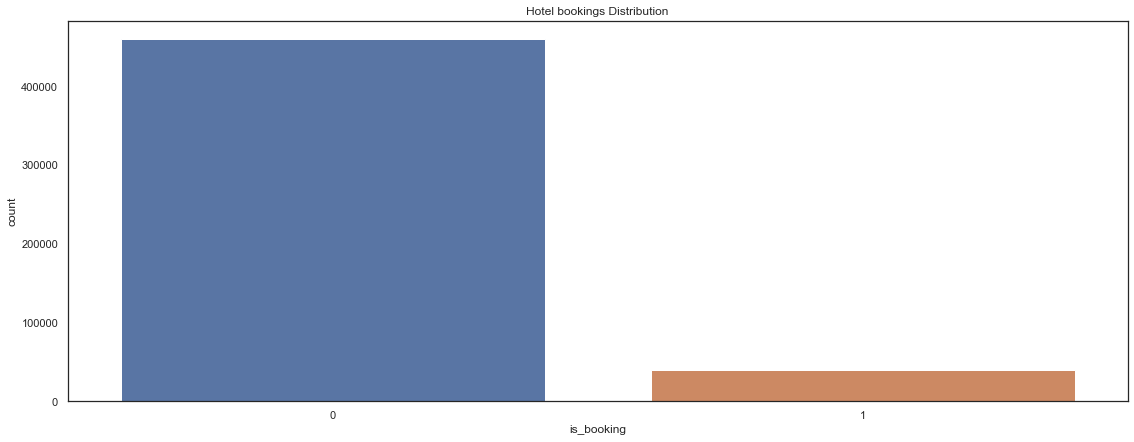

In [69]:
# booking distribution

sns.set(style='white')
plt.figure(figsize=(19,7))

sns.countplot(data=hotels,x='is_booking')
plt.title('Hotel bookings Distribution');

#### _Insights:_

It shows that there are majority of clicks than actual bookings in the data set.

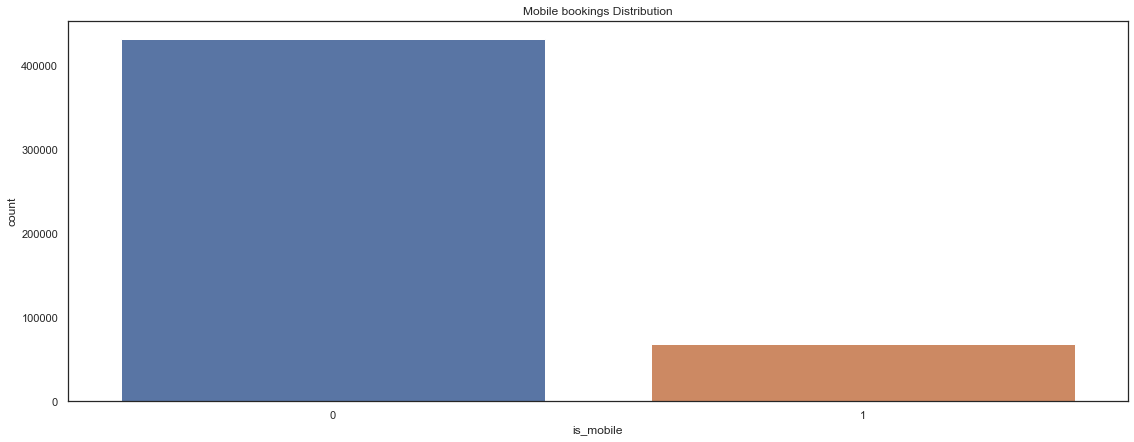

In [70]:
# Mobile booking distribution

sns.set(style='white')
plt.figure(figsize=(19,7))

sns.countplot(data=hotels,x='is_mobile')
plt.title('Mobile bookings Distribution');

#### _Insights:_

The above bar chart shows tha the majority users prefered non-mobile to book hotels

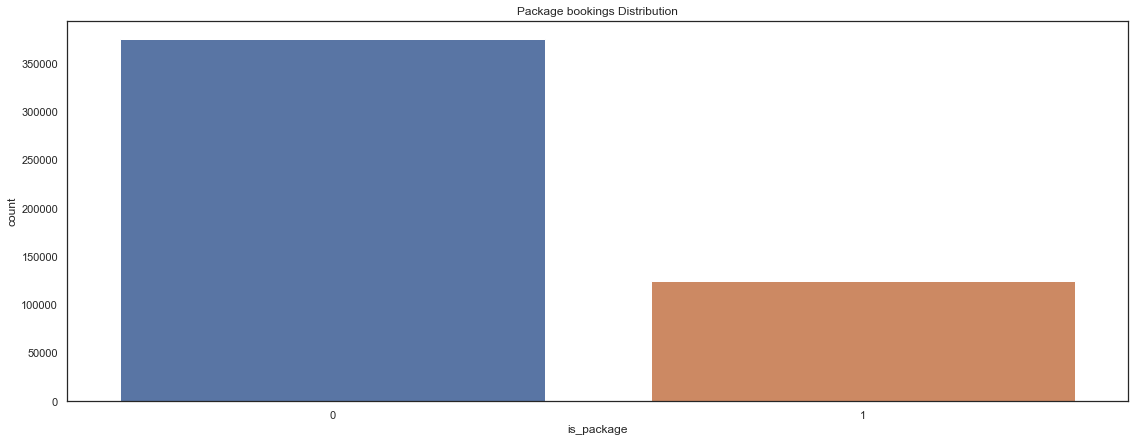

In [71]:
# package distribution

sns.set(style='white')
plt.figure(figsize=(19,7))

sns.countplot(data=hotels,x='is_package')
plt.title('Package bookings Distribution');

#### _Insights:_

It shows that user prefered non-package booking comapred to package ones

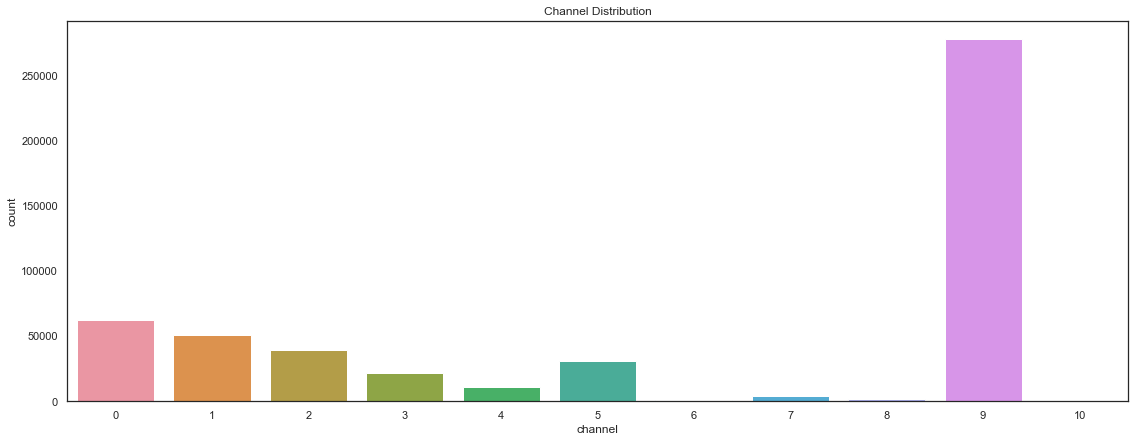

In [72]:
# Channel distribution

sns.set(style='white')
plt.figure(figsize=(19,7))

sns.countplot(data=hotels,x='channel')
plt.title('Channel Distribution');

#### _Insights:_

Based on above bar chart, we see that channel 9 is mostly used than other channel.

In [102]:
# check correlation among the variables 

hotels_corr = hotels.drop(['srch_ci','srch_destination_id','srch_destination_type_id','hotel_continent','ci_year'],axis=1)

hotels_corr.corr()

,posa_continent,user_location_country,is_mobile,is_package,channel,is_booking,hotel_country,hotel_market,hotel_cluster,ci_month,ci_week
posa_continent,1.000000,0.175873,0.014894,-0.094759,0.090916,0.011646,-0.154963,0.048809,0.016828,-0.012086,-0.004929
user_location_country,0.175873,1.000000,0.005995,-0.023455,0.104623,0.008314,0.093413,0.017715,-0.010291,-0.017791,-0.009534
is_mobile,0.014894,0.005995,1.000000,0.056236,-0.033986,-0.031044,-0.027198,0.007352,0.010558,0.004236,-0.000004
is_package,-0.094759,-0.023455,0.056236,1.000000,-0.007932,-0.076145,-0.039972,-0.015151,0.038440,-0.033916,-0.030838
channel,0.090916,0.104623,-0.033986,-0.007932,1.000000,0.023474,0.001182,0.002616,0.000317,-0.014198,-0.009931
is_booking,0.011646,0.008314,-0.031044,-0.076145,0.023474,1.000000,-0.004970,0.013656,-0.021677,-0.001325,0.001704
hotel_country,-0.154963,0.093413,-0.027198,-0.039972,0.001182,-0.004970,1.000000,0.019398,-0.027446,0.006290,0.003569
hotel_market,0.048809,0.017715,0.007352,-0.015151,0.002616,0.013656,0.019398,1.000000,0.032303,-0.000312,0.002031
hotel_cluster,0.016828,-0.010291,0.010558,0.038440,0.000317,-0.021677,-0.027446,0.032303,1.000000,-0.001762,-0.001721
ci_month,-0.012086,-0.017791,0.004236,-0.033916,-0.014198,-0.001325,0.006290,-0.000312,-0.001762,1.000000,0.907186


#### _Insights:_

Based on above correlation matrix, we do not see any strong correlation with hotel cluster but there are few features having negative correlation such as user country, hotel country, check in month, booking etc.

## Modeling:

- Split the data into train and test
- train the models using different ML algorithms
- test the model with highest score

In [77]:
# import required packages

from sklearn.model_selection import train_test_split

X = hotels.drop(['hotel_cluster','srch_ci'],axis=1)
y = hotels['hotel_cluster'].values

In [80]:
# split data into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#### Linear Regression:

In [93]:
from sklearn.linear_model import LinearRegression

# fit model no training data
reg = LinearRegression()

reg.fit(X_train, y_train)

LinearRegression()

In [94]:
# make predictions for test data

y_pred = reg.predict(X_test)

predictions = [round(value) for value in y_pred]

In [95]:
# evaluate predictions

from sklearn.metrics import accuracy_score

accuracy_reg = accuracy_score(y_test, predictions)

print("Accuracy: %.2f%%" % (accuracy_reg * 100.0))

Accuracy: 1.35%


#### Linear regression using stat model:

In [97]:
feature_names = X.columns

X_features = pd.DataFrame(X,columns=feature_names)  # to see features names in model summary

In [98]:
# use statsmodel to run linear regression model

import statsmodels.api as sm 

reg_stat = sm.OLS(y, sm.add_constant(X_features)).fit()

In [99]:
# print the summary of model result

reg_stat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     168.9
Date:                Sun, 30 Jan 2022   Prob (F-statistic):               0.00
Time:                        20:45:41   Log-Likelihood:            -2.3909e+06
No. Observations:              500000   AIC:                         4.782e+06
Df Residuals:                  499985   BIC:                         4.782e+06
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     -404.1739    144.247     -2.802      0.005    -686.893    -121.455
posa_continent               0.6113      0.059     10.307      0.000       0.495       0.728
user_location_country       -0.0051      0.001     -7.213      0.000      -0.007      -0.004
is_mobile                    0.5476      0.120      4.578      0.000       0.313       0.782
is_package                   2.1630      0.099     21.915      0.000       1.970       2.356
channel                      0.0134      0.011      1.206      0.228      -0.008       0.035
srch_destination_id       1.094e-05   4.14e-06      2.642      0.008    2.82e-06    1.91e-05
srch_destination_type_id    -0.3644      0.022    -16.929      0.000      -0.407      -0.322
is_booking                  -1.9935      0.151    -13.172      0.000      -2.290      -1.697
hotel_continent             -0.1170      0.028     -4.183      0.000      -0.172      -0.062
hotel_country               -0.0114      0.001    -14.704      0.000      -0.013      -0.010
hotel_market                 0.0019   8.05e-05     23.055      0.000       0.002       0.002
ci_year                      0.2251      0.072      3.143      0.002       0.085       0.365
ci_month                     0.0044      0.029      0.151      0.880      -0.052       0.061
ci_week                     -0.0003      0.007     -0.043      0.966      -0.013       0.013
==============================================================================
Omnibus:                   246809.105   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26430.867
Skew:                           0.004   Prob(JB):                         0.00
Kurtosis:                       1.874   Cond. No.                     6.46e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.46e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### XGBoost - 

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

In [87]:
from xgboost import XGBClassifier

# fit model no training data
model = XGBClassifier()

model.fit(X_train, y_train)

/Users/ganeshkale/work/virtual_envs/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:01:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [88]:
# make predictions for test data

y_pred = model.predict(X_test)

predictions = [round(value) for value in y_pred]

In [92]:
# evaluate predictions

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predictions)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 15.52%


## Summary:

Based on accuracy of different algorithms used to predict the hotel cluster, the XGBoost is accuracy score is better.
Since the data used to build the prediction model is sample of actual dataset so could be the reason that lower accuracy score.
Also, the correlation Metrix does not show any strong correlation with hotel cluster.
Based on EDA performed, we see that the users from country code 66 prefer to book hotel cluster 91 but this data is sample so same trend may or may not be visible in actual data set.

Overall, the XGBoost model is baselined model and can be used for predicting the hotel to users based on their activities and demographic information.


# END